In [2]:
import yfinance as yf
import pandas as pd

# Define stock ticker
ticker = "AAPL"

# Fetch historical data
data = yf.download(ticker, start="2024-01-01", end="2025-02-07", interval="1d")

# Fetch real-time data (latest trading day)
real_time_data = yf.Ticker(ticker).history(period="1d")

print(data.tail())  # Print last few rows of historical data
print(real_time_data)  # Print real-time data


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2025-01-31  236.000000  247.190002  233.440002  247.190002  101075100
2025-02-03  228.009995  231.830002  225.699997  229.990005   73063300
2025-02-04  232.800003  233.130005  226.649994  227.250000   45067300
2025-02-05  232.470001  232.669998  228.270004  228.529999   39620300
2025-02-06  231.270004  233.800003  230.425003  231.339996   13567135
                                 Open        High         Low       Close  \
Date                                                                        
2025-02-06 00:00:00-05:00  231.339996  233.800003  230.425003  231.270004   

                             Volume  Dividends  Stock Splits  
Date                                                          
2025-02-06 00:00:00-05:00  13567135        0.0           0.0  


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Use only 'Close' price as feature
data = data[['Close']]

# Normalize data (LSTM works best with normalized inputs)
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

# Convert back to DataFrame
data_scaled = pd.DataFrame(data_scaled, index=data.index, columns=['Close'])
print(data_scaled.head())  # Print first few rows


               Close
Date                
2024-01-02  0.214869
2024-01-03  0.200250
2024-01-04  0.175639
2024-01-05  0.167961
2024-01-08  0.214028


In [4]:
import torch

# Convert data to PyTorch tensor
def create_sequences(data, lookback=50):
    sequences, targets = [], []
    for i in range(len(data) - lookback):
        sequences.append(data[i:i+lookback])  # Last 'lookback' days as input
        targets.append(data[i+lookback])  # Next day's price as target
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Use last 50 days to predict next day
lookback = 50
X, y = create_sequences(data_scaled.values, lookback)

# Split into training (80%) and testing (20%) sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training Samples: {X_train.shape}, Test Samples: {X_test.shape}")


Training Samples: torch.Size([180, 50, 1]), Test Samples: torch.Size([46, 50, 1])


/tmp/ipykernel_25024/165011438.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


In [5]:
import torch.nn as nn

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output one value (next-day price)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]  # Take the last timestep output
        return self.fc(last_output)

# Initialize Model
model = LSTMModel()
print(model)



LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [6]:
import torch.optim as optim

# Define Loss & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 50
for epoch in range(epochs):
    model.train()
    
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = criterion(predictions, y_train)
    
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 10/50, Loss: 0.1015
Epoch 20/50, Loss: 0.0566
Epoch 30/50, Loss: 0.0463
Epoch 40/50, Loss: 0.0338
Epoch 50/50, Loss: 0.0192


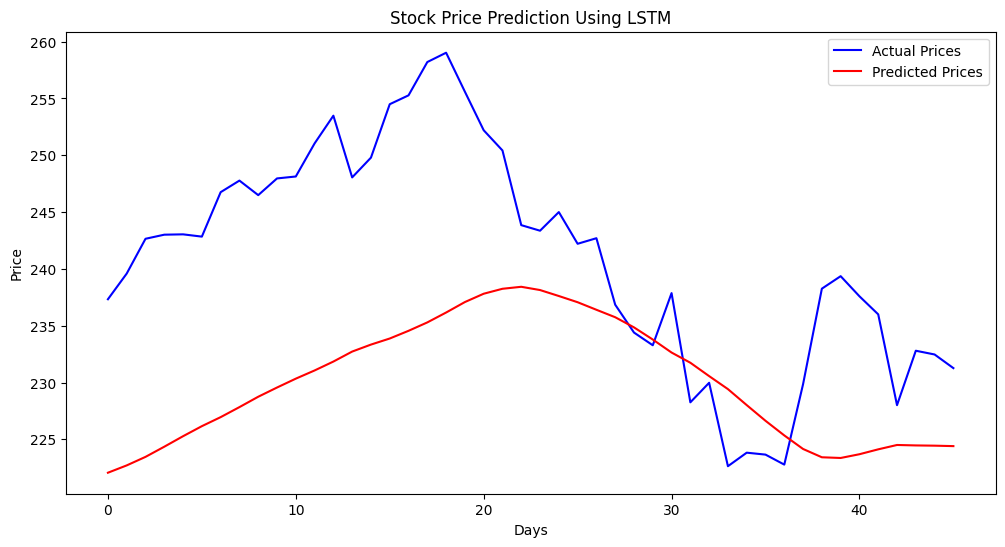

In [7]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

# Convert back to original price scale
test_predictions = scaler.inverse_transform(test_predictions.numpy())
y_test_actual = scaler.inverse_transform(y_test.numpy())

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Prices", color="blue")
plt.plot(test_predictions, label="Predicted Prices", color="red")
plt.title("Stock Price Prediction Using LSTM")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()



[*********************100%***********************]  1 of 1 completed


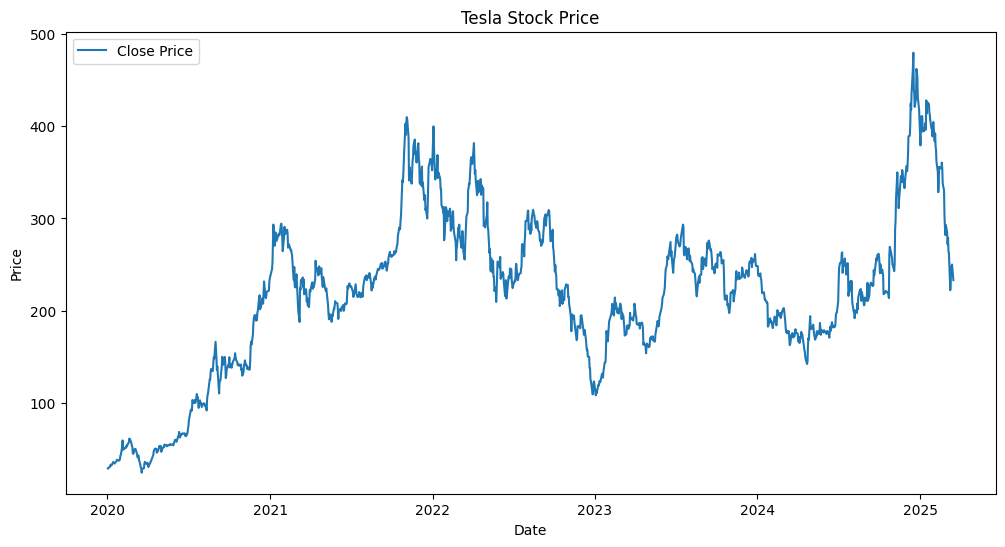

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

data = yf.download('TSLA', start='2020-01-01', end='2025-03-18', auto_adjust=False)

data = data[['Adj Close']]
data.rename(columns={'Adj Close': 'Close'}, inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price')
plt.title('Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

In [7]:
def create_dataset(dataset, lookback=60):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        X.append(dataset[i:(i+lookback), 0])
        y.append(dataset[i+lookback, 0])
    return np.array(X), np.array(y)

dataset = data.values
lookback = 60

X, y = create_dataset(dataset, lookback)

In [8]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

X_train = X_train.reshape(-1, lookback, 1)
X_test = X_test.reshape(-1, lookback, 1)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

In [16]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    optimizer.zero_grad()
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        # 在測試集上評估
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch 10/100, Loss: 0.1146, Test Loss: 0.1604
Epoch 20/100, Loss: 0.0468, Test Loss: 0.0319
Epoch 30/100, Loss: 0.0266, Test Loss: 0.0523
Epoch 40/100, Loss: 0.0205, Test Loss: 0.0309
Epoch 50/100, Loss: 0.0184, Test Loss: 0.0254
Epoch 60/100, Loss: 0.0142, Test Loss: 0.0202
Epoch 70/100, Loss: 0.0074, Test Loss: 0.0066
Epoch 80/100, Loss: 0.0049, Test Loss: 0.0206
Epoch 90/100, Loss: 0.0034, Test Loss: 0.0047
Epoch 100/100, Loss: 0.0028, Test Loss: 0.0043


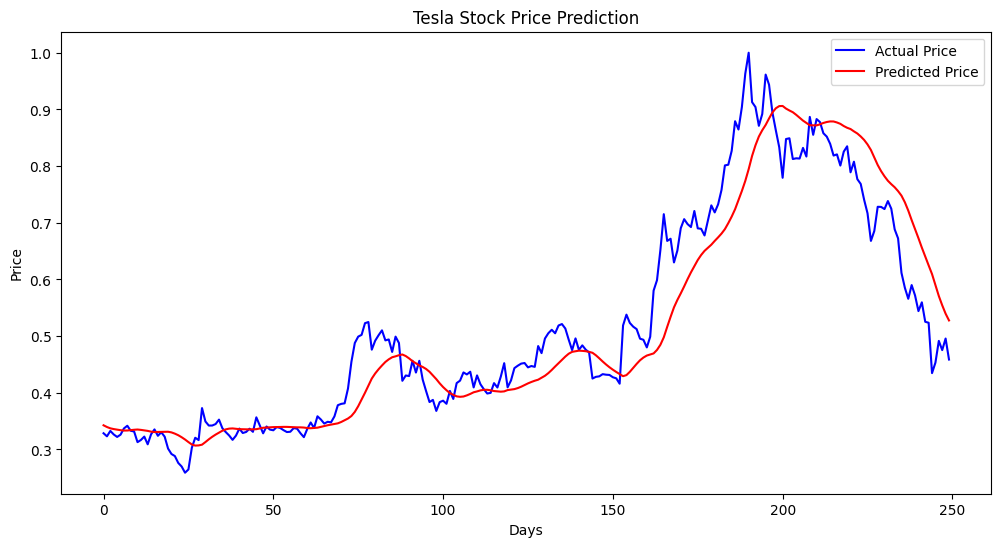

In [17]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(test_predict, label='Predicted Price', color='red')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error

train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 0.05
Test RMSE: 0.07
